# AGN Spectrum Quick Exploration

Welcome to this mini‑workshop! In the next few steps you will download an optical spectrum of an active galactic nucleus (AGN) from the Sloan Digital Sky Survey (SDSS), visualise it, and fit some basic spectral features.

## Setup

We start by importing the necessary Python packages. If you are running this in Google Colab for the first time you may need to install some of them using `pip install`.

In [ ]:
# Uncomment the next line if packages are missing in Colab
#!pip install numpy scipy matplotlib astropy astroquery
!pip install astroquery astropy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.1 MB/s eta 0:00:00


In [ ]:
#Import some necessary packages

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy import units as u
from astropy import constants as const

from scipy.optimize import curve_fit

%matplotlib inline

In [ ]:
#Mounting Google Drive Here:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# List files in your MyDrive
#!ls /content/drive/MyDrive

# Download data files and put them into your Google Drive
# Call the folder, "NARIT_Youth_Research_2025"
# Change to a project folder

import os
os.chdir('/content/drive/MyDrive/...')


## Choose an AGN target

A few AGN coordinates are provided in `data/agn_targets.csv`. You can use one of these or supply your own coordinates.

In this example we will load the CSV file and select the first entry.

In [ ]:
# Use Pandas to develop a data frame

import pandas as pd

csv_path = 'data/...'  # adjust path if necessary
df = pd.read_csv(csv_path)
print(f'The table contains {len(df)} AGN entries.')
df.head()


The table contains 40878 AGN entries.


,specObjID,ra,dec,u,err_u,g,err_g,r,err_r,i,...,spectroFlux_u,spectroFluxIvar_u,spectroFlux_g,spectroFluxIvar_g,spectroFlux_r,spectroFluxIvar_r,spectroFlux_i,spectroFluxIvar_i,spectroFlux_z,spectroFluxIvar_z
0,961627961662924800,205.527367,5.089971,17.24312,0.008712,17.12692,0.004209,16.88774,0.004199,16.84807,...,94.272620,1.329245,104.260100,3.374295,134.029700,2.201848,136.15840,1.679969,202.49170,0.790631
1,7201334800795586560,130.273531,44.108804,20.73387,0.072431,20.28794,0.025602,20.09188,0.030066,19.69925,...,6.429861,1.903253,7.129987,14.501150,7.657137,10.219570,10.06271,7.592605,11.33003,2.839128
2,532639748741687296,138.748222,2.586392,17.89646,0.014938,17.56299,0.006085,17.05423,0.005189,16.70033,...,36.364980,0.987725,44.658330,1.766435,69.617350,1.666925,96.60953,1.402571,106.13530,0.639603
3,529214770021165056,136.521454,0.047926,19.84063,0.053406,19.22997,0.015623,18.51402,0.012645,18.10305,...,5.160207,1.222138,9.456963,3.278702,17.468800,3.063213,23.28798,2.430623,25.31125,1.266187
4,8262077660471250944,214.371964,53.307371,19.76099,0.040386,19.32400,0.013422,18.56183,0.010332,18.08352,...,12.298420,1.518151,13.832560,6.713978,23.723320,5.452270,35.26195,4.171300,45.02294,1.771778


In [ ]:
#Test some outputs
df['specObjID'][0]

In [ ]:
# Choose the first target
target = ...

name     = df['specObjID'][target]
ra       = float(df['ra'][target])
dec      = float(df['...'][target])
fiberID  = int(df['...'][target])
plate    = int(df['...'][target])
mjd      = int(df['...'][target])
redshift = float(df['...'][target])

print(f'Selected target: {name} (RA={ra} deg, Dec={dec} deg), fiberID={fiberID}, plate#={plate}, MJD={mjd} days, redshift={redshift}')


Selected target: 7201334800795586560 (RA=130.27353124793 deg, Dec=44.1088039069181 deg), fiberID=287, plate#=6396, MJD=56358 days, redshift=0.5242076


## Download the SDSS spectrum

The `astroquery.sdss` module allows us to query the SDSS database. We use the RA and Dec coordinates to find the nearest spectrum and download it.
BUT, if you have the precise plate number, MJD, and FiberID, you can use SDSS.get_spectra directly without having to resolve source first.

In [ ]:
# Create a SkyCoord object for the target
coord = coords.SkyCoord(ra, dec, unit='deg')

# Query the SDSS spectroscopic database around this position
xid = SDSS.query_region(coord, radius=2*u.arcsec, spectro=True)

# Inspect the returned table to find plate, MJD and fiber ID
print(xid[['plate', 'mjd', 'fiberID', 'ra', 'dec']])

# Take the first spectrum
plate = int(xid['plate'][0])
mjd   = int(xid['mjd'][0])
fiber = int(xid['fiberID'][0])

# Fetch the spectrum using plate-mjd-fiber
spec = SDSS.get_spectra(plate=..., mjd=..., fiberID=...)[0]

plate  mjd  fiberID        ra             dec       
----- ----- ------- --------------- ----------------
 6396 56358     287 130.27353124793 44.1088039069181


In [ ]:
#Set restframe wavelength of some important emission lines in Angstrom

wvl_rest_Halpha = 6563.0
wvl_rest_Hbeta = ...

wvl_rest_MgII = ....

wvl_rest_OIIIa = ...
wvl_rest_OIIIb = ....

wvl_rest_NIIa = ....
wvl_rest_NIIb = ....

wvl_rest_SIIa = .....
wvl_rest_SIIb = .....

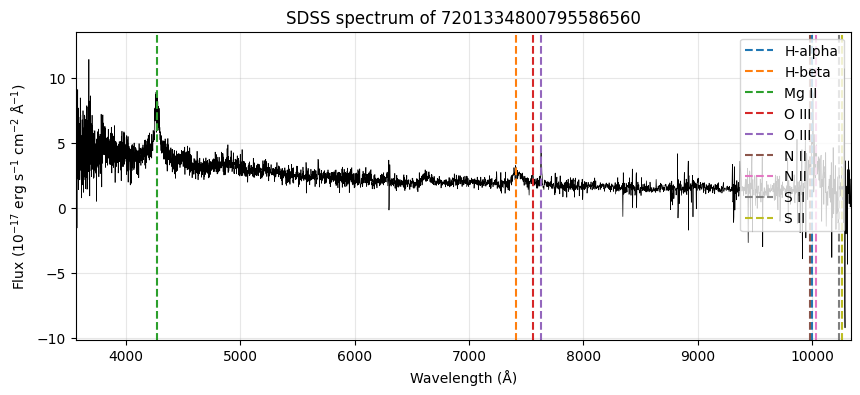

In [ ]:
# Extract flux and wavelength from the spectrum
data = spec[1].data
flux = data['flux']
loglam = data['loglam']
wave = ...  # convert log10 wavelength to angstroms

# Plot the full spectrum
plt.figure(figsize=(10, 4))
plt.plot(wave, flux, color='black', lw=0.5)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux ($10^{-17}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
plt.title(f'SDSS spectrum of {name}')

plt.plot([wvl_rest_Halpha*(1+redshift),wvl_rest_Halpha*(1+redshift)],[-20,20], 'C0--', label='H-alpha')
plt.plot([wvl_rest_Hbeta*(1+redshift),wvl_rest_Hbeta*(1+redshift)],[-20,20], 'C1--', label='H-beta')
plt.plot([wvl_rest_MgII*(1+redshift),wvl_rest_MgII*(1+redshift)],[-20,20], 'C2--', label='Mg II')
plt.plot([wvl_rest_OIIIa*(1+redshift),wvl_rest_OIIIa*(1+redshift)],[-20,20], 'C3--', label='O III')
plt.plot([wvl_rest_OIIIb*(1+redshift),wvl_rest_OIIIb*(1+redshift)],[-20,20], 'C4--', label='O III')
plt.plot([wvl_rest_NIIa*(1+redshift),wvl_rest_NIIa*(1+redshift)],[-20,20], 'C5--', label='N II')
plt.plot([wvl_rest_NIIb*(1+redshift),wvl_rest_NIIb*(1+redshift)],[-20,20], 'C6--', label='N II')
plt.plot([wvl_rest_SIIa*(1+redshift),wvl_rest_SIIa*(1+redshift)],[-20,20], 'C7--', label='S II')
plt.plot([wvl_rest_SIIb*(1+redshift),wvl_rest_SIIb*(1+redshift)],[-20,20], 'C8--', label='S II')

plt.legend()

plt.xlim(wave.min(), wave.max())
plt.ylim(1.1*flux.min(), 1.1*flux.max())
plt.grid(True, alpha=0.3)
plt.show()

## Fit the continuum

Spectra often show a smooth continuum with superimposed emission and absorption lines. To fit a specific line we need to estimate the continuum around it. In this example we will focus on the **H‑β region** (around 4861 Å). We select two wavelength windows on either side of the line to fit a first‑order polynomial (straight line) as the continuum.

/tmp/ipython-input-2642465155.py:13: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(wave_cont, flux_cont, deg=4)


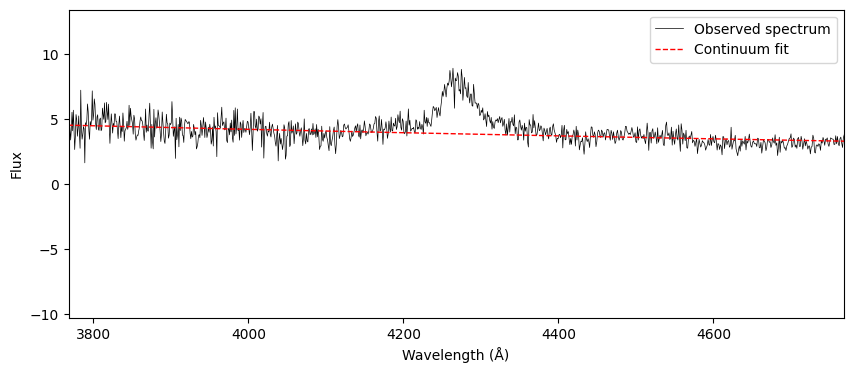

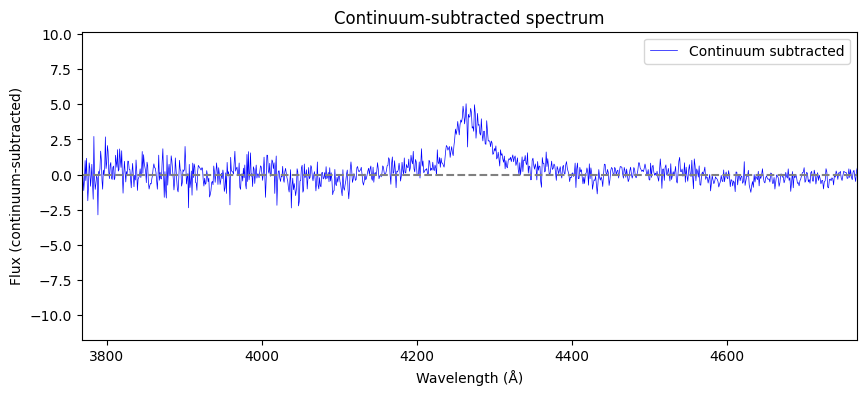

In [ ]:
# Choose a region around the emission line (H-beta ~4861 Å)
line_center = ...
window = ...  # half-width of the window around the line in angstroms
exp_line_width = ...
wing = ... # continuum wings in Angstrom

# Define sidebands for continuum fitting: a few hundreds Å below and above the emission line
mask_cont = ((wave > (line_center + (0.5*exp_line_width))) & (wave > (line_center + (0.5*exp_line_width + wing)))) | ((wave < (line_center - (0.5*exp_line_width))) & (wave < (line_center - (0.5*exp_line_width + wing))))
wave_cont = wave[mask_cont]
flux_cont = flux[mask_cont]

# Fit a first-order polynomial to the continuum
coeffs = np.polyfit(wave_cont, flux_cont, deg=4)
cont_fit = np.polyval(coeffs, wave)

# Subtract continuum to isolate the emission line
flux_line = flux - cont_fit

# Plot continuum fit and residual
plt.figure(figsize=(10, 4))
plt.plot(wave, flux, 'k', lw=0.5, label='Observed spectrum')
plt.plot(wave, cont_fit, 'r--', lw=1, label='Continuum fit')
plt.xlim(line_center - window, line_center + window)
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(wave, flux_line, 'b', lw=0.5, label='Continuum subtracted')
plt.xlim(line_center - window, line_center + window)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (continuum-subtracted)')
plt.title('Continuum-subtracted spectrum')
plt.legend()
plt.show()

## Fit the emission line

We can model an emission or absorption line with a Gaussian profile.  Below we define a Gaussian function and use `curve_fit` to estimate the amplitude, centre, and width of the MgII line.

Best-fit parameters:
  Amplitude = 3.796
  Center    = 4270.98 Å
  Sigma     = 26.08 Å
  FWHM      = 61.41 Å
  Sigma [km/s]    = 1831.79 [km/s]
  FWHM  [km/s]    = 4313.86 [km/s]


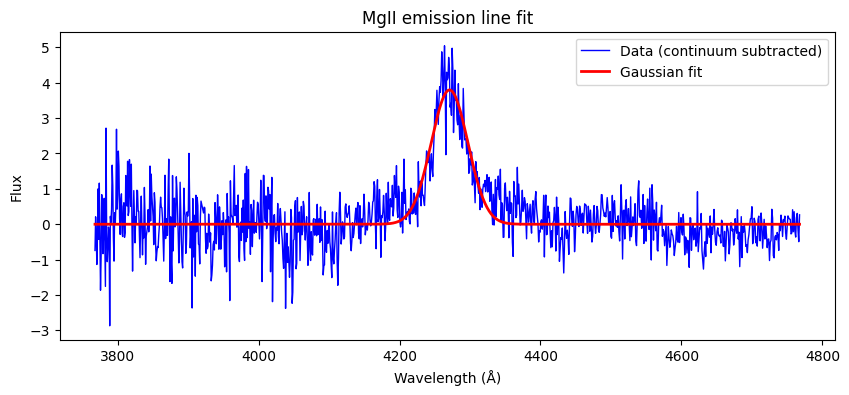

In [ ]:
# Define Gaussian function
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-0.5 * ((x - mu) / sigma)**2)

c_speed_kms = ...

# Select a fitting window around the line
mask_line = (wave > line_center - window) & (wave < line_center + window)
wave_fit  = wave[mask_line]
flux_fit  = flux_line[mask_line]

# Initial guess: amplitude ~ max, mu ~ line_center, sigma ~ 10 Å
p0 = [... , ... , ...]

popt, pcov = curve_fit(gaussian, wave_fit, flux_fit, p0=p0)

amp, mu, sigma = popt
fwhm = 2.355 * sigma  # convert sigma to FWHM

print('Best-fit parameters:')
print(f'  Amplitude = {amp:.3f}')
print(f'  Center    = {mu:.2f} Å')
print(f'  Sigma     = {sigma:.2f} Å')
print(f'  FWHM      = {fwhm:.2f} Å')
print(f'  Sigma [km/s]    = {sigma*c_speed_kms/line_center:.2f} [km/s]')
print(f'  FWHM  [km/s]    = {fwhm*c_speed_kms/line_center:.2f} [km/s]')


# Plot the fit
model = gaussian(wave_fit, *popt)
plt.figure(figsize=(10, 4))
plt.plot(wave_fit, flux_fit, 'b', lw=1, label='Data (continuum subtracted)')
plt.plot(wave_fit, model, 'r', lw=2, label='Gaussian fit')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.title('MgII emission line fit')
plt.legend()
plt.show()

## Fit an absorption line (optional)

Some AGN spectra show absorption features, mainly contributed by their host galaxies. You can adapt the same Gaussian fitting procedure above, but allow the amplitude to be negative to model absorption.

Try changing the `line_center` variable to a wavelength where you see an absorption trough, adjust the fitting window, and run the cells again.

## Next steps

You have downloaded an AGN spectrum, visualised it, and fit basic continuum and emission line models.  Feel free to explore other lines (e.g., H‑α at 6563 Å, or [O III] at 5007 Å), or other objects.